In [24]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!nvidia-smi

Sun Sep 11 07:59:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

## 데이터 EDA

In [27]:
sys.path.append(os.pardir)
sys.path.append('/content/drive/My Drive/청경채 성장 예측/open-2')
folder_name = 'open-2'
file_path = os.path.join('/content/drive/My Drive/청경채 성장 예측', folder_name)

In [28]:
all_input_list = sorted(glob.glob(os.path.join(file_path, 'train_input/*.csv')))
all_target_list = sorted(glob.glob(os.path.join(file_path, 'train_target/*.csv')))

In [29]:
train_x = pd.DataFrame()
train_y = pd.DataFrame()
for input_path, target_path in tqdm(zip(all_input_list, all_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
            
  input_df = input_df.drop(columns=['시간'])
  target_df = target_df.drop(columns=['시간'])          
  
  train_x = pd.concat([train_x, input_df])
  train_y = pd.concat([train_y, target_df])
  

0it [00:00, ?it/s]

In [30]:
test_input_list = sorted(glob.glob(os.path.join(file_path, 'test_input/*.csv')))
test_target_list = sorted(glob.glob(os.path.join(file_path, 'test_target/*.csv')))

In [31]:
test_x = pd.DataFrame()
test_y = pd.DataFrame()
for input_path, target_path in tqdm(zip(test_input_list, test_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
            
  input_df = input_df.drop(columns=['시간'])
  # target_df = target_df.drop(columns=['시간'])          
  
  test_x = pd.concat([test_x, input_df])
  test_y = pd.concat([test_y, target_df])
    

0it [00:00, ?it/s]

In [32]:
test_x.head(10)

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,외부온도추정관측치,외부습도추정관측치,펌프최근분무량,펌프일간누적분무량
0,22.1,19.4,487.0,0.023535,20.200001,26.799999,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,22.1,19.5,485.0,0.022630,20.100000,26.799999,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,22.1,19.5,488.0,0.023535,20.100000,26.700001,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,22.1,19.5,486.0,0.022630,20.000000,26.799999,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,22.1,19.5,481.0,0.022630,20.000000,26.900000,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,22.1,19.5,481.0,0.022630,19.900000,26.900000,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,22.1,19.5,484.0,0.022630,19.799999,27.000000,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
7,22.1,19.5,480.0,0.022630,19.799999,27.000000,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,22.1,19.5,485.0,0.022630,19.799999,27.100000,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
9,22.1,19.5,481.0,0.021725,19.799999,27.100000,0.0,0.0,0.0,0.0,...,0.0,5.500002,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [33]:
print(f'train_x shape: {train_x.shape}, train_y shape:{train_y.shape}') 

train_x shape: (2611507, 42), train_y shape:(1813, 1)


In [34]:
train_x.head(10)

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,펌프작동남은시간.1,외부온도추정관측치,외부습도추정관측치,펌프최근분무량,펌프일간누적분무량
0,24.799999,40.500000,361.0,0.059069,20.299999,33.200001,0.0,0.0,0.0,0.0,...,37.596000,363.554,309.41,16.548,37.596,NaN,NaN,NaN,NaN,NaN
1,20.500000,44.099998,355.0,0.910134,19.700001,10.700000,0.0,0.0,0.0,0.0,...,2.500000,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2,20.600000,44.299999,360.0,0.910134,19.799999,10.600000,0.0,0.0,0.0,0.0,...,3.000002,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
3,20.600000,44.500000,359.0,0.908579,19.799999,10.400000,0.0,0.0,0.0,0.0,...,3.000002,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
4,20.600000,44.500000,357.0,0.910134,19.799999,10.300000,0.0,0.0,0.0,0.0,...,3.000002,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
5,20.700001,44.500000,355.0,0.912465,19.799999,10.400000,0.0,0.0,0.0,0.0,...,3.500004,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
6,20.799999,44.000000,360.0,0.914020,19.700001,10.200000,0.0,0.0,0.0,0.0,...,3.999996,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7,20.500000,43.500000,355.0,0.912465,19.700001,10.100000,0.0,0.0,0.0,0.0,...,2.500000,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
8,20.400000,43.299999,357.0,0.911688,19.700001,10.100000,0.0,0.0,0.0,0.0,...,2.249999,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN
9,20.299999,43.400002,356.0,0.909356,19.700001,10.100000,0.0,0.0,0.0,0.0,...,1.999998,0.000,0.00,0.000,0.000,NaN,NaN,NaN,NaN,NaN


In [35]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2611507 entries, 0 to 35999
Data columns (total 42 columns):
 #   Column         Dtype  
---  ------         -----  
 0   내부온도관측치        float64
 1   내부습도관측치        float64
 2   CO2관측치         float64
 3   EC관측치          float64
 4   외부온도관측치        float64
 5   외부습도관측치        float64
 6   펌프상태           float64
 7   펌프작동남은시간       float64
 8   최근분무량          float64
 9   일간누적분무량        float64
 10  냉방상태           float64
 11  냉방작동남은시간       float64
 12  난방상태           float64
 13  난방작동남은시간       float64
 14  내부유동팬상태        float64
 15  내부유동팬작동남은시간    float64
 16  외부환기팬상태        float64
 17  외부환기팬작동남은시간    float64
 18  화이트 LED상태      float64
 19  화이트 LED작동남은시간  float64
 20  화이트 LED동작강도    float64
 21  레드 LED상태       float64
 22  레드 LED작동남은시간   float64
 23  레드 LED동작강도     float64
 24  블루 LED상태       float64
 25  블루 LED작동남은시간   float64
 26  블루 LED동작강도     float64
 27  카메라상태          float64
 28  냉방온도           float64
 29  난방온도           f

In [36]:
train_x.describe()

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,펌프작동남은시간.1,외부온도추정관측치,외부습도추정관측치,펌프최근분무량,펌프일간누적분무량
count,2.538185e+06,2.538185e+06,2.538185e+06,2.538185e+06,1.533000e+06,1.533000e+06,2.538185e+06,2.538185e+06,2.031257e+06,1.910299e+06,...,2.538185e+06,2.538185e+06,2.538185e+06,2.538185e+06,2.538185e+06,120958.000000,665649.000000,665649.000000,506928.000000,5.069280e+05
mean,2.448577e+01,7.030827e+01,5.022626e+02,1.910333e+00,2.507982e+01,4.049044e+01,3.509225e+00,9.700953e+00,1.159870e+03,7.280724e+03,...,2.485470e+01,1.837002e+02,1.360668e+02,2.378328e+01,2.310281e+01,710.739771,22.716451,28.247654,1587.201428,1.060260e+04
std,4.096520e+00,5.041845e+03,1.379173e+02,3.430858e+00,6.990801e+00,1.952280e+01,2.623644e+01,8.280084e+02,1.637057e+04,4.792193e+04,...,3.138053e+01,1.845644e+02,1.452608e+02,4.016355e+01,4.118914e+01,191.099315,5.569186,11.447516,26031.441000,9.786339e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,-5.597816e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.210000e+01,5.810000e+01,4.220000e+02,5.456138e-01,2.170000e+01,2.424000e+01,0.000000e+00,0.000000e+00,1.260000e+02,7.625700e+02,...,9.499998e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,762.570000,20.877777,20.500000,93.850000,1.538000e+03
50%,2.485000e+01,6.980000e+01,4.810000e+02,1.356623e+00,2.450000e+01,4.150000e+01,0.000000e+00,0.000000e+00,5.310900e+02,2.587040e+03,...,1.750000e+01,1.610650e+02,2.978640e+01,0.000000e+00,0.000000e+00,769.000000,22.799999,27.580000,769.000000,3.788360e+03
75%,2.730000e+01,7.890000e+01,5.600000e+02,2.182126e+00,2.740000e+01,5.460000e+01,0.000000e+00,0.000000e+00,7.690000e+02,6.139140e+03,...,3.600000e+01,3.588545e+02,3.094100e+02,3.144120e+01,3.446300e+01,769.000000,24.900000,34.599998,769.000000,8.459000e+03
max,4.501667e+01,8.001986e+06,3.259000e+03,3.542000e+03,9.080000e+01,2.010000e+02,2.010000e+02,9.999900e+04,6.429974e+05,6.492690e+05,...,4.035995e+02,5.825000e+03,5.825000e+03,1.654800e+02,1.566500e+02,769.000000,41.720001,75.699997,642990.970000,3.214055e+06


In [37]:
print(train_x.columns)

Index(['내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치', '펌프상태',
       '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태', '난방작동남은시간',
       '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간', '화이트 LED상태',
       '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
       '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
       '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량', '펌프작동남은시간.1', '외부온도추정관측치', '외부습도추정관측치', '펌프최근분무량',
       '펌프일간누적분무량'],
      dtype='object')


### 결측치 처리

In [38]:
train_y.isnull().sum()

rate    0
dtype: int64

In [39]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

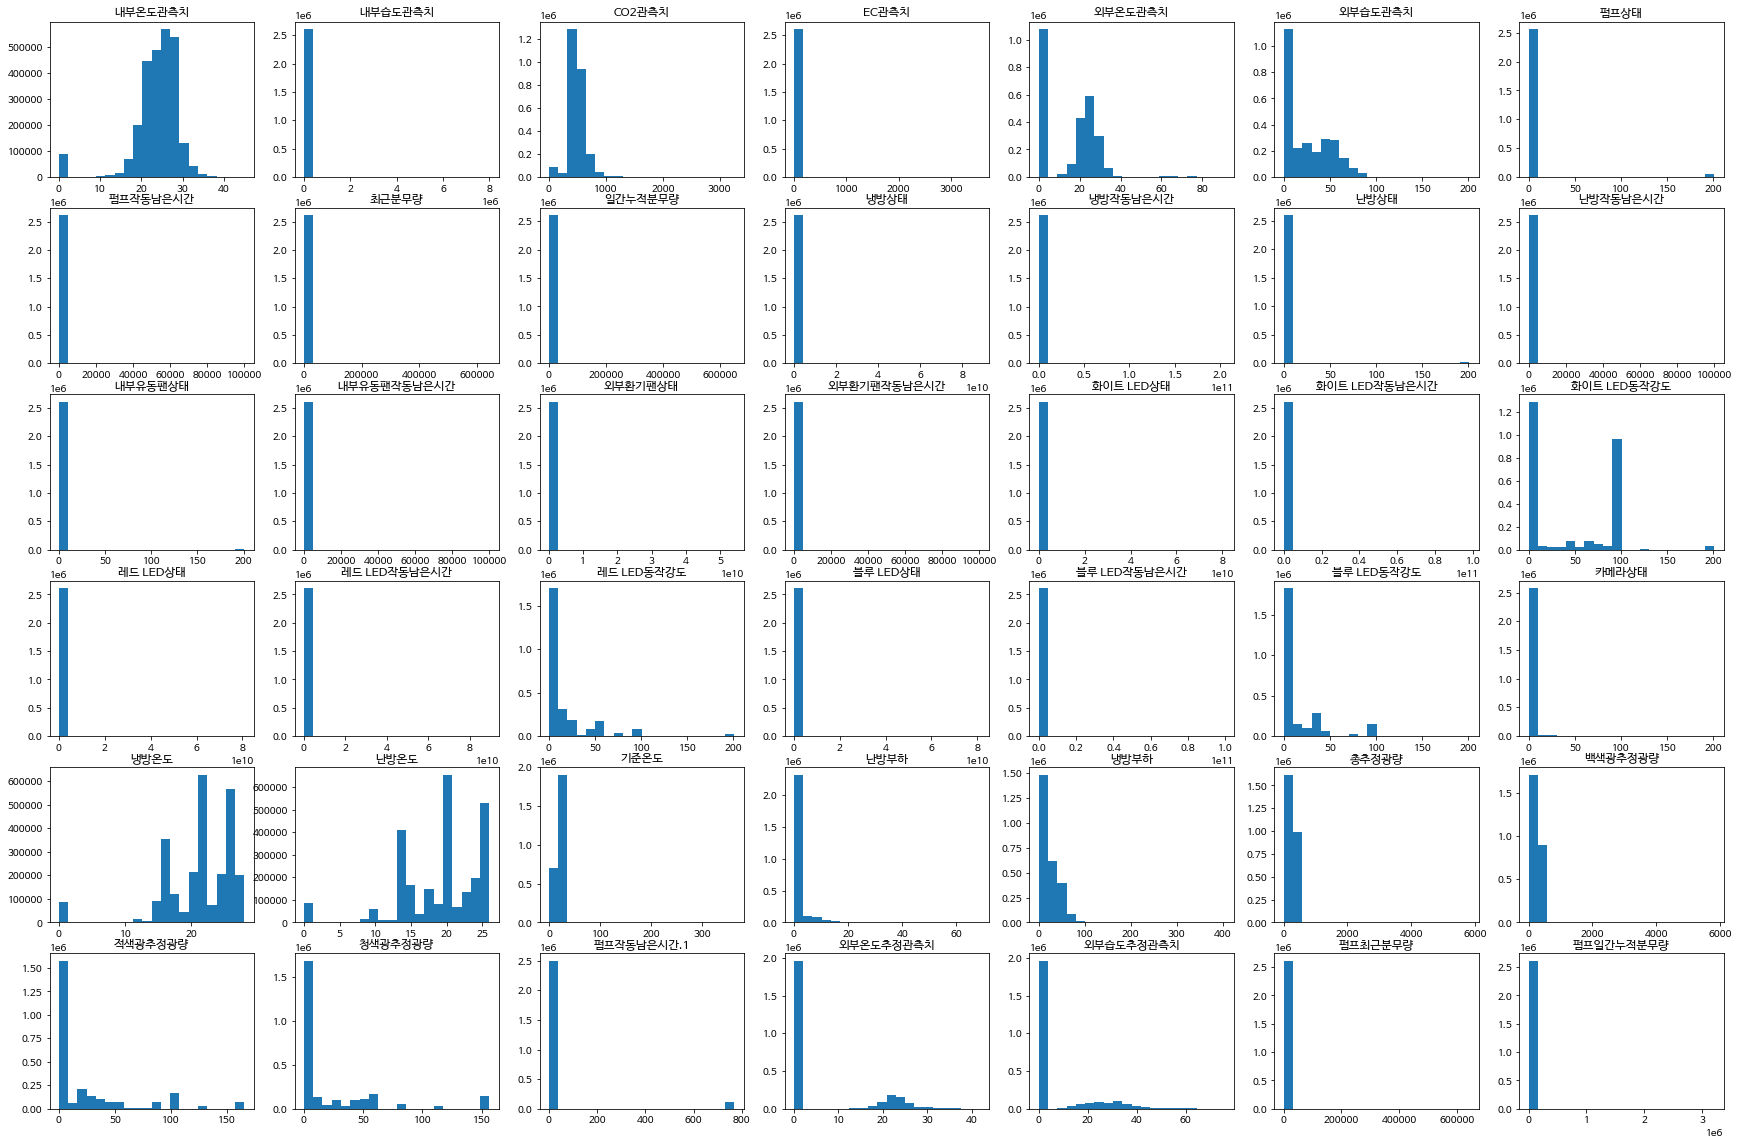

<Figure size 432x288 with 0 Axes>

In [40]:
# train data의 각 칼럼별 분포 확인
plt.figure(figsize=(30,20))
plt.rc('font', family='NanumBarunGothic')
train_x_zero_filled = train_x.fillna(0)
for i, col in enumerate(train_x_zero_filled.columns, 1):
  plt.subplot(6,7,i)
  plt.hist(train_x_zero_filled[col], bins=20)
  plt.title(col)
plt.show()
plt.savefig(file_path+'/train_x_histogram.png')

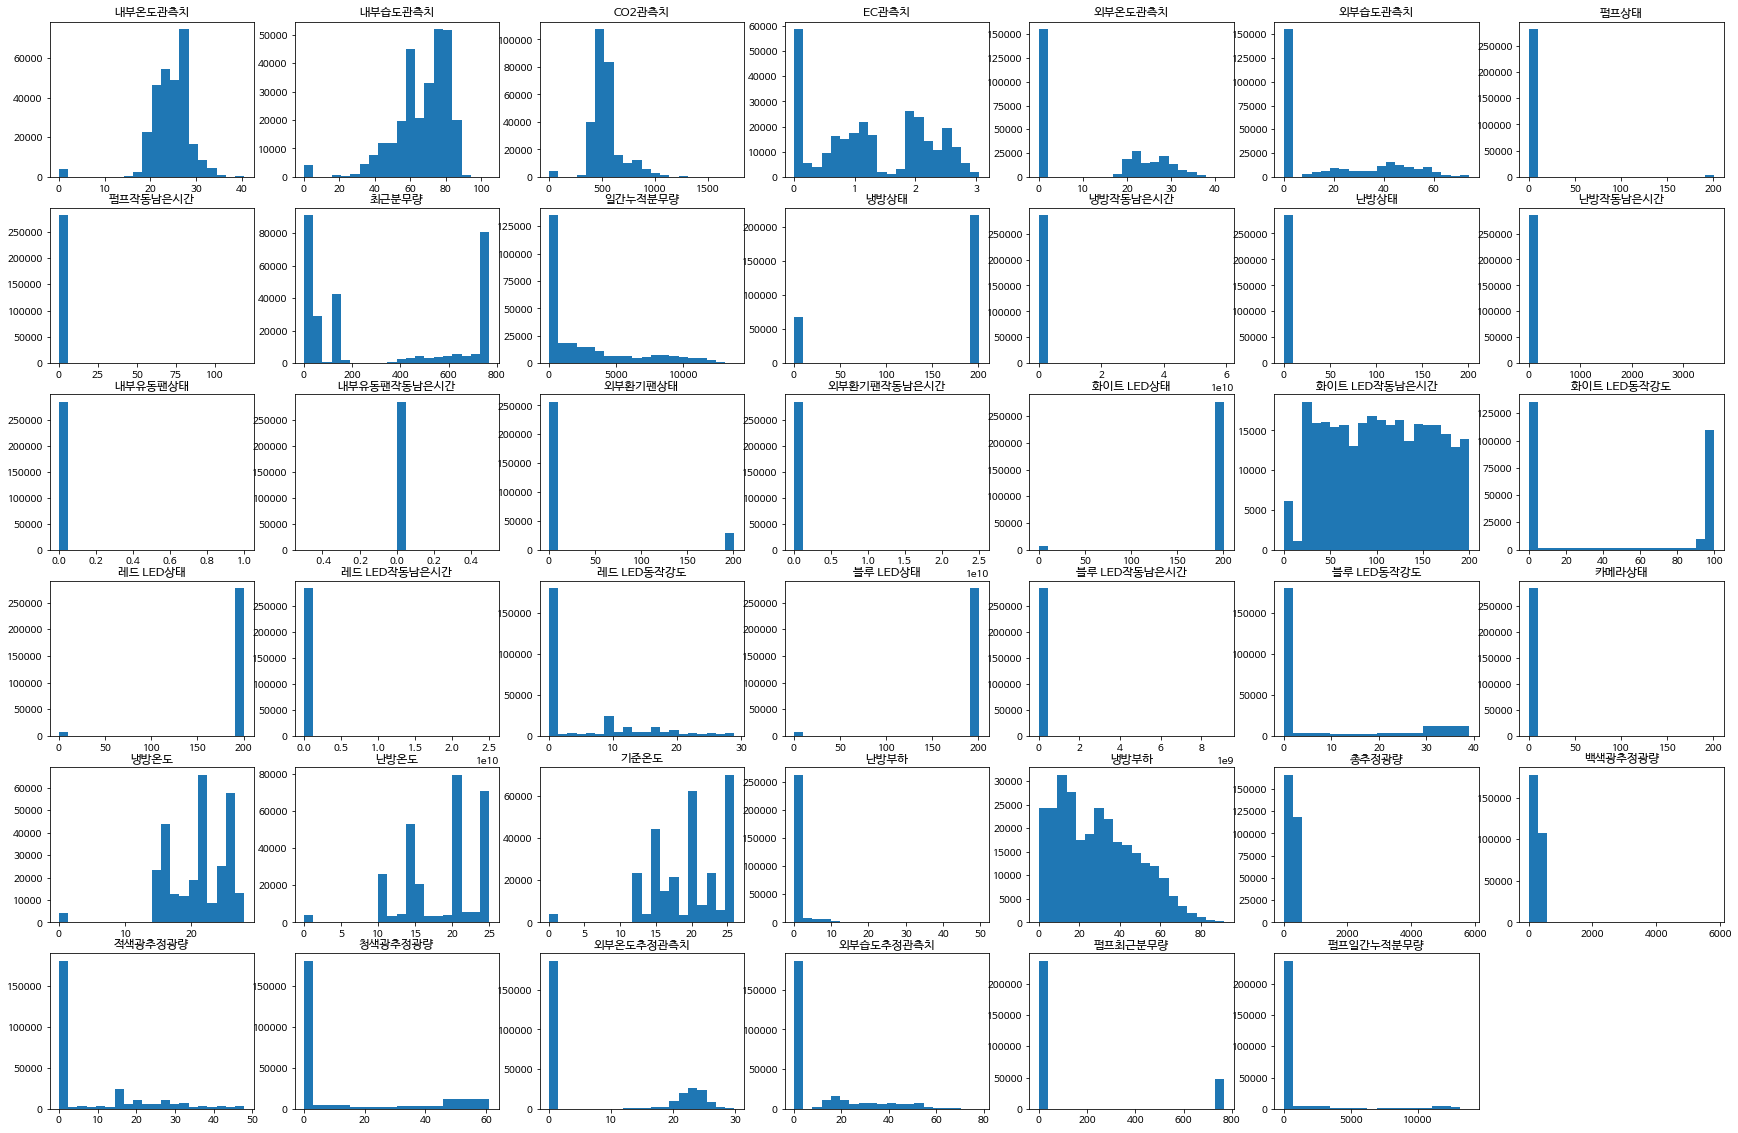

<Figure size 432x288 with 0 Axes>

In [41]:
# test data의 각 칼럼별 분포 확인
plt.figure(figsize=(30,20))
plt.rc('font', family='NanumBarunGothic')
test_x_zero_filled = test_x.fillna(0)
for i, col in enumerate(test_x_zero_filled.columns, 1):
  plt.subplot(6,7,i)
  plt.hist(test_x_zero_filled[col], bins=20)
  plt.title(col)
plt.show()
plt.savefig(file_path+'/test_x_histogram.png')

In [42]:
# 각 칼럼별 결측치 개수와 결측치 개수가 차지하는 비율 구하기
total_row = train_x.shape[0]
for col in train_x.columns:
  null_num = train_x[col].isnull().sum()
  not_null_num = total_row - null_num
  print(f'Column:{col}, NumberofNull:{null_num}, NumberofNotNull:{not_null_num}, Ratio:{null_num*100/total_row}\n')

Column:내부온도관측치, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:내부습도관측치, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:CO2관측치, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:EC관측치, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:외부온도관측치, NumberofNull:1078507, NumberofNotNull:1533000, Ratio:41.29826188480445

Column:외부습도관측치, NumberofNull:1078507, NumberofNotNull:1533000, Ratio:41.29826188480445

Column:펌프상태, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:펌프작동남은시간, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:최근분무량, NumberofNull:580250, NumberofNotNull:2031257, Ratio:22.218971651234327

Column:일간누적분무량, NumberofNull:701208, NumberofNotNull:1910299, Ratio:26.850703444409685

Column:냉방상태, NumberofNull:73322, NumberofNotNull:2538185, Ratio:2.8076509080772136

Column:냉방작동남은시간, NumberofNull:73322, NumberofNotN

### 이상치 제거

In [43]:
# 이상치 제거로 클리핑 방법을 사용 - 상한과 하한을 설정한 뒤 해당 범위를 벗어나는 값은 상한값과 하한값으로 치환함
p05 = train_x.quantile(0.05)
p95 = train_x.quantile(0.95)

train_x = train_x.clip(p05, p95, axis=1)
test_x = test_x.clip(p05, p95, axis=1)

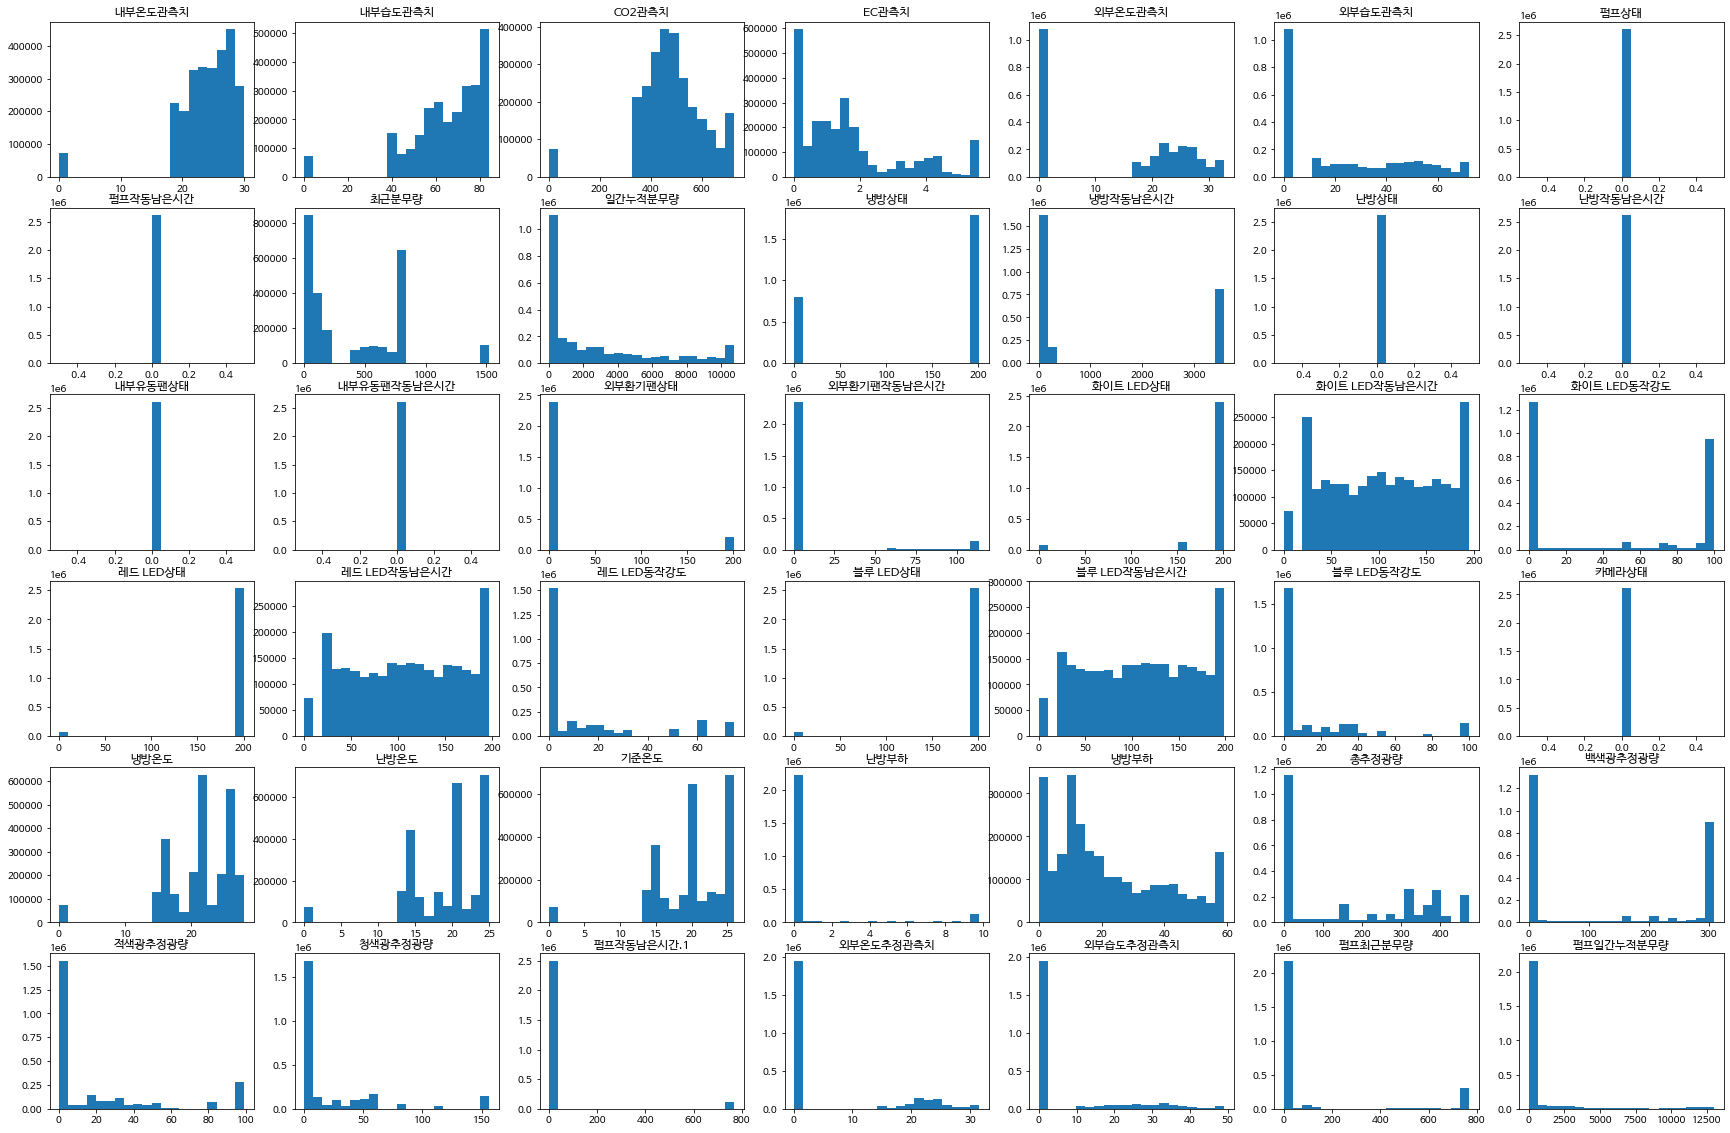

<Figure size 432x288 with 0 Axes>

In [44]:
# 이상치를 제거한 뒤의 train data의 각 칼럼별 분포 확인
plt.figure(figsize=(30,20))
plt.rc('font', family='NanumBarunGothic')
train_x_zero_filled = train_x.fillna(0)
for i, col in enumerate(train_x_zero_filled.columns, 1):
  plt.subplot(6,7,i)
  plt.hist(train_x_zero_filled[col], bins=20)
  plt.title(col)
plt.show()
plt.savefig(file_path+'/train_x_histogram.png')

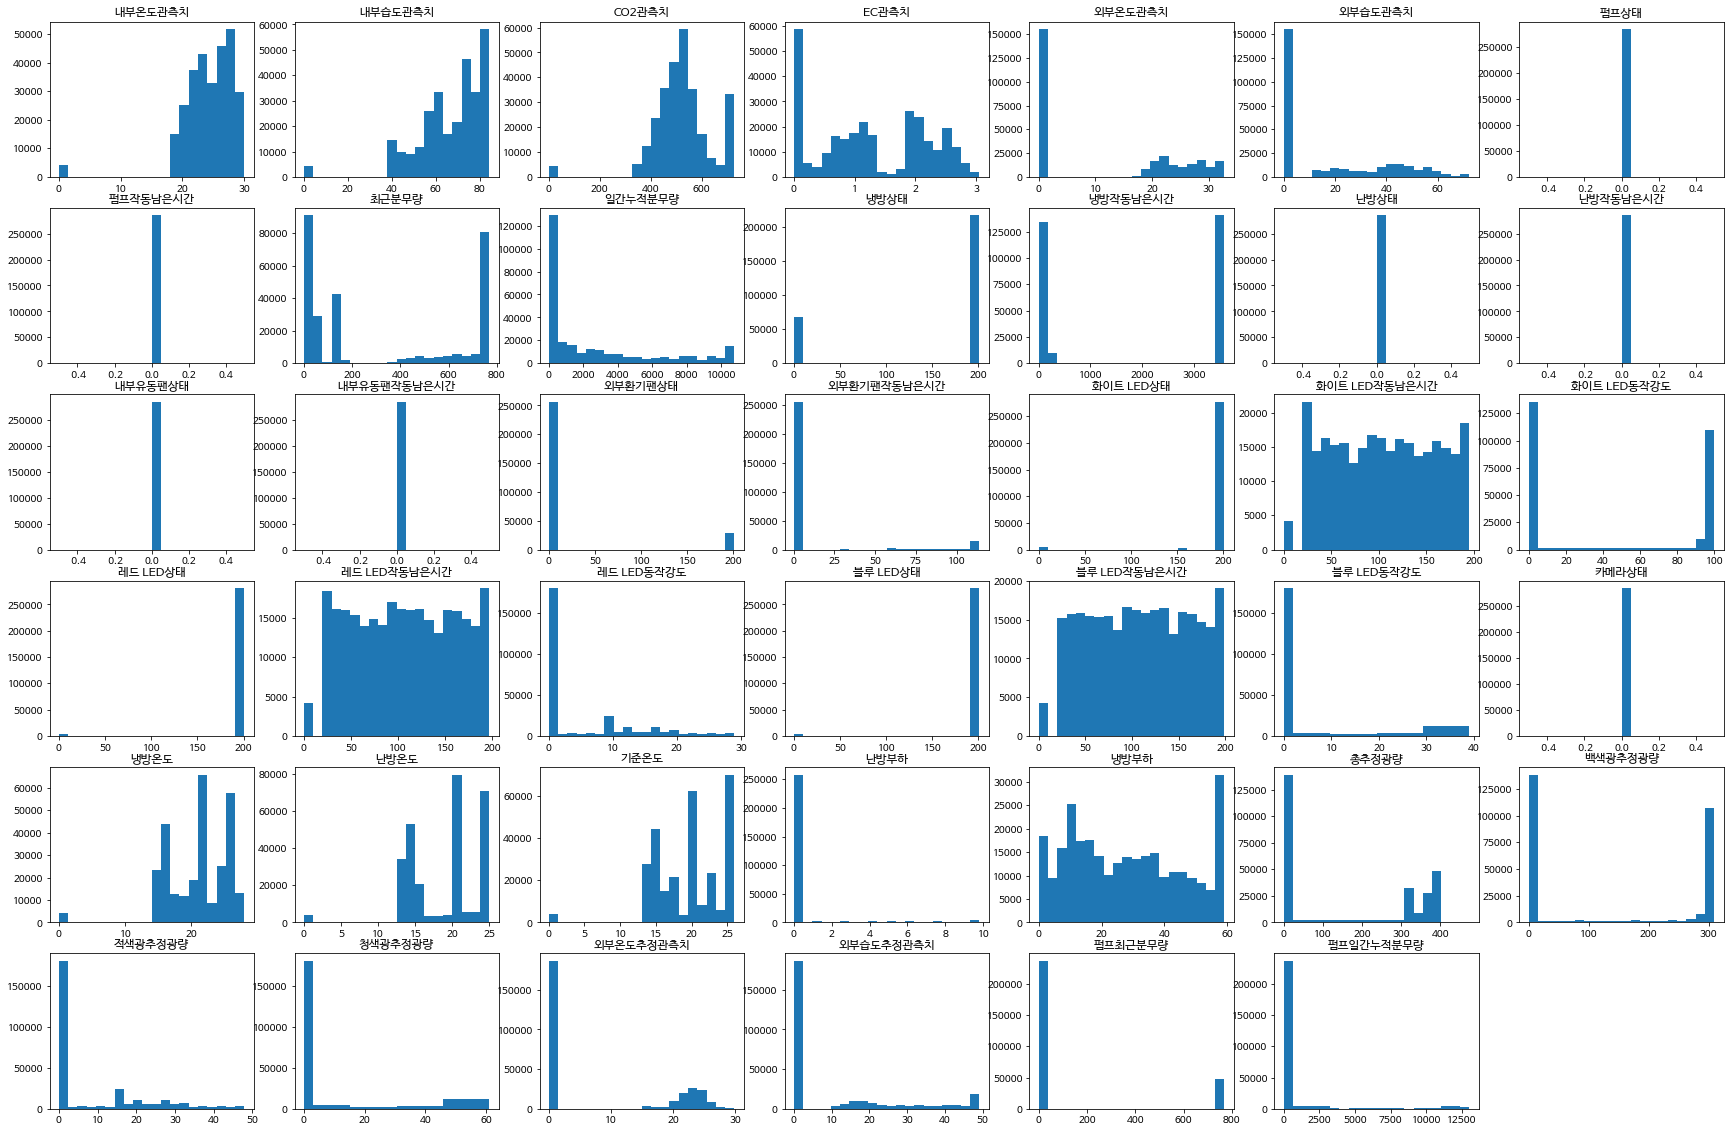

<Figure size 432x288 with 0 Axes>

In [45]:
# 이상치를 제거한 뒤의 test data의 각 칼럼별 분포 확인
plt.figure(figsize=(30,20))
plt.rc('font', family='NanumBarunGothic')
test_x_zero_filled = test_x.fillna(0)
for i, col in enumerate(test_x_zero_filled.columns, 1):
  plt.subplot(6,7,i)
  plt.hist(test_x_zero_filled[col], bins=20)
  plt.title(col)
plt.show()
plt.savefig(file_path+'/test_x_histogram.png')

#### 결측치 처리방법
1. '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치', '최근분무량', '일간누적분무량', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED작동남은시간', '블루 LED동작강도', '냉방온도', '난방온도', '기준온도', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', '외부온도추정관측치', '외부습도추정관측치'
를 제외한 나머지는 모두 null 값을 median또는 mean으로 만들기
2. '펌프상태', '펌프작동남은시간', '펌프작동남은시간.1', '난방상태', '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간' 는 제거하기
3. '펌프최근분무량', '펌프일간누적분무량' 는 제거해야할지 말지를 두번의 케이스로 나눠서 테스트 해보자
  - 제거하지 않았을때 성능이 그다지 향상되지 않았다.
  - 제거했을떄도 성능이 그다지 향상되지 않았다.

#### Case1) '펌프최근분무량', '펌프일간누적분무량' 를 그대로 유지함

In [46]:
# fill_median_cols = train_x.columns.tolist()
# modifying_cols = ['내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치', '최근분무량', '일간누적분무량', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED작동남은시간', '블루 LED동작강도', '냉방온도', '난방온도', '기준온도', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', '외부온도추정관측치']
# deleting_cols = ['펌프작동남은시간.1', '난방상태', '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간']
# for col in train_x.columns:
#   if (col in modifying_cols) or (col in deleting_cols):
#     fill_median_cols.remove(col)


#### Case2) '펌프최근분무량', '펌프일간누적분무량' 를 제거함

In [47]:
fill_median_cols = train_x.columns.tolist()
modifying_cols = ['내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치', '최근분무량', '일간누적분무량', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED작동남은시간', '블루 LED동작강도', '냉방온도', '난방온도', '기준온도', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', '외부온도추정관측치']
deleting_cols = ['펌프상태', '펌프작동남은시간', '펌프작동남은시간.1', '난방상태', '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '펌프최근분무량', '펌프일간누적분무량']
for col in train_x.columns:
  if (col in modifying_cols) or (col in deleting_cols):
    fill_median_cols.remove(col)

In [48]:
train_x[fill_median_cols].describe()

,냉방상태,냉방작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,레드 LED상태,블루 LED상태,카메라상태,난방부하,외부습도추정관측치
count,2.538185e+06,2.538185e+06,2.538185e+06,2.538185e+06,2.538185e+06,2538185.0,2538185.0,2538185.0,2.538185e+06,665649.000000
mean,1.423517e+02,1.199191e+03,1.668196e+01,9.658467e+00,1.983724e+02,201.0,201.0,0.0,9.510078e-01,28.215406
std,9.078741e+01,1.633321e+03,5.530742e+01,2.996462e+01,1.106385e+01,0.0,0.0,0.0,2.593249e+00,9.964563
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.510000e+02,201.0,201.0,0.0,0.000000e+00,11.800000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.010000e+02,201.0,201.0,0.0,0.000000e+00,20.500000
50%,2.010000e+02,1.280000e+02,0.000000e+00,0.000000e+00,2.010000e+02,201.0,201.0,0.0,0.000000e+00,27.580000
75%,2.010000e+02,3.549000e+03,0.000000e+00,0.000000e+00,2.010000e+02,201.0,201.0,0.0,0.000000e+00,34.599998
max,2.010000e+02,3.592000e+03,2.010000e+02,1.140000e+02,2.010000e+02,201.0,201.0,0.0,9.799997e+00,49.139999


In [49]:
test_x[fill_median_cols].describe()

,냉방상태,냉방작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,레드 LED상태,블루 LED상태,카메라상태,난방부하,외부습도추정관측치
count,280917.000000,280917.000000,280917.000000,280917.000000,280917.000000,280917.0,280917.0,280917.0,280917.000000,98597.000000
mean,155.305697,1820.618738,20.372966,10.167357,200.330705,201.0,201.0,0.0,0.535918,30.416794
std,84.055788,1751.318003,60.568429,30.289794,5.731641,0.0,0.0,0.0,1.880366,12.809121
min,0.000000,0.000000,0.000000,0.000000,151.000000,201.0,201.0,0.0,0.000000,11.800000
25%,201.000000,44.000000,0.000000,0.000000,201.000000,201.0,201.0,0.0,0.000000,18.340000
50%,201.000000,3278.021845,0.000000,0.000000,201.000000,201.0,201.0,0.0,0.000000,28.799999
75%,201.000000,3568.000000,0.000000,0.000000,201.000000,201.0,201.0,0.0,0.000000,42.860001
max,201.000000,3592.000000,201.000000,114.000000,201.000000,201.0,201.0,0.0,9.799997,49.139999


In [50]:
# fill_median_cols 의 결측치를 중앙값으로 채움
train_x[fill_median_cols] = train_x[fill_median_cols].fillna(train_x[fill_median_cols].median())
test_x[fill_median_cols] = test_x[fill_median_cols].fillna(test_x[fill_median_cols].median())

In [51]:
train_x = train_x.drop(columns=deleting_cols)

In [52]:
deleting_cols.remove('펌프작동남은시간.1')
test_x = test_x.drop(columns=deleting_cols)

In [53]:
# train data와 test data의 열의 개수 일치여부를 확인
print(train_x.shape[1] == test_x.shape[1])

True


#### 모든 열에 rankgauss를 적용함

In [54]:
## modifying_col에만 rankgauss 적용
# from sklearn.preprocessing import QuantileTransformer

# transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
# transformer.fit(train_x[modifying_cols])

# train_x[modifying_cols] = transformer.transform(train_x[modifying_cols])
# test_x[modifying_cols] = transformer.transform(test_x[modifying_cols])

In [55]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
transformer.fit(train_x)

all_columns = train_x.columns
train_x[all_columns] = transformer.transform(train_x[all_columns])
test_x[all_columns] = transformer.transform(test_x[all_columns])

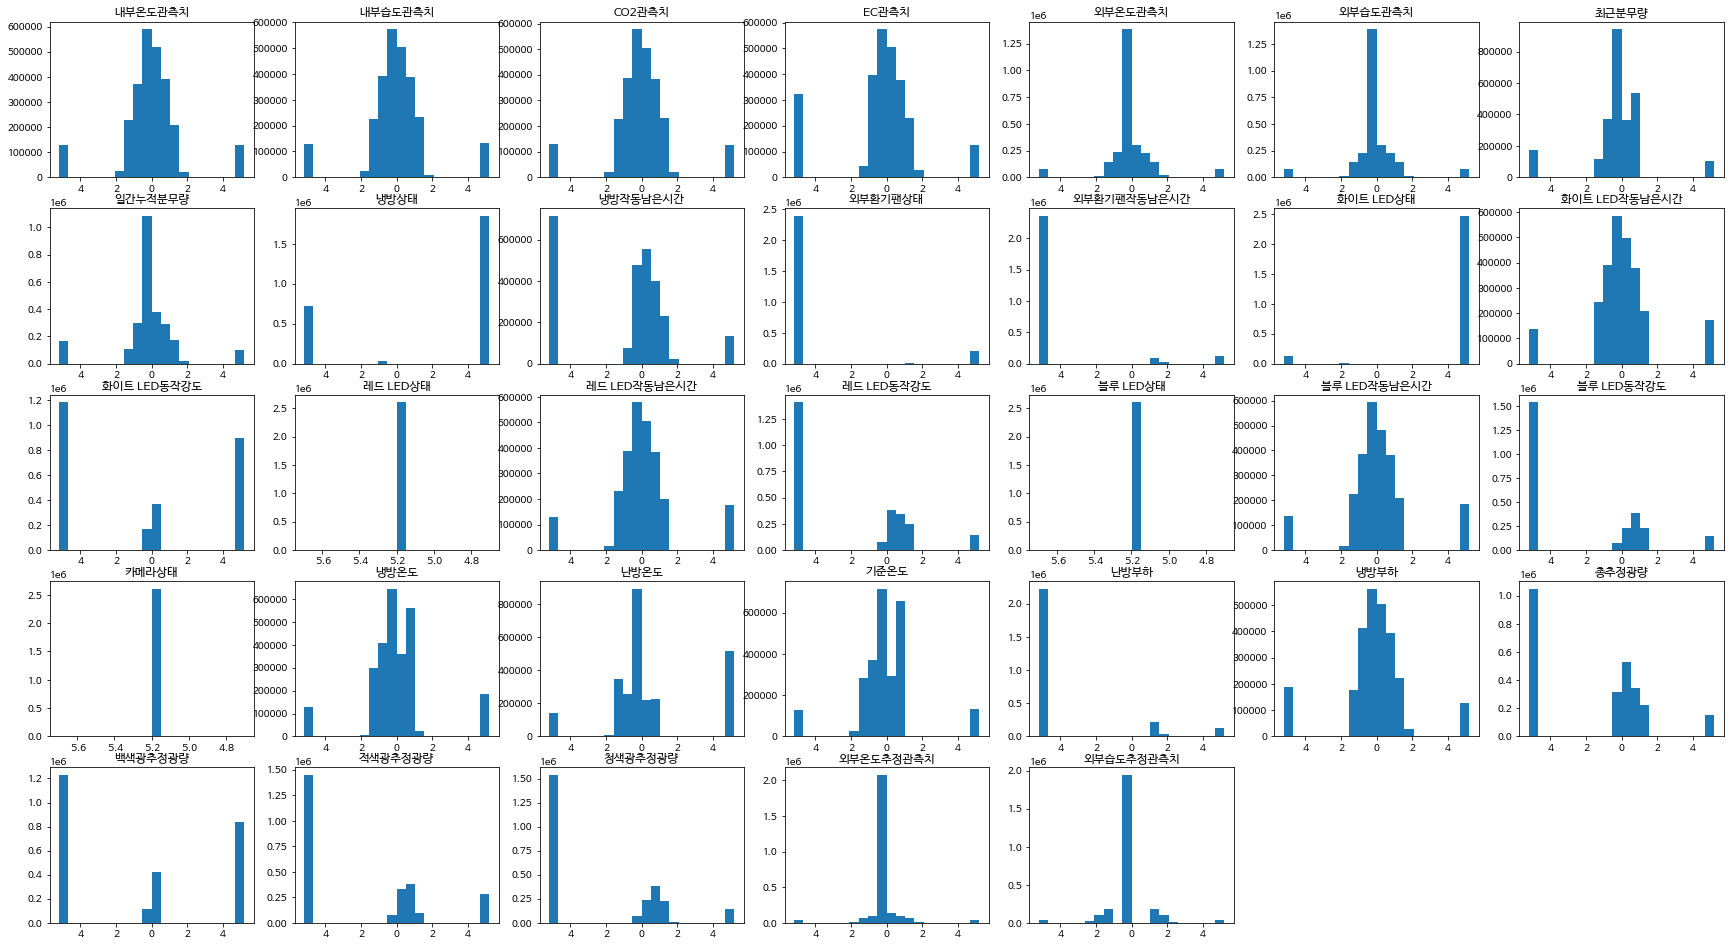

<Figure size 432x288 with 0 Axes>

In [56]:
# rankgauss를 적용한 train data의 각 열의 분포 확인
plt.figure(figsize=(30,20))
plt.rc('font', family='NanumBarunGothic')
train_x_zero_filled = train_x.fillna(0)
for i, col in enumerate(train_x_zero_filled.columns, 1):
  plt.subplot(6,7,i)
  plt.hist(train_x_zero_filled[col], bins=20)
  plt.title(col)
plt.show()
plt.savefig(file_path+'/train_x_transformed_histogram.png')

#### 결측치를 평균값으로 대체함

In [57]:
train_x[modifying_cols] = train_x[modifying_cols].fillna(train_x[modifying_cols].mean())
test_x[modifying_cols] = test_x[modifying_cols].fillna(test_x[modifying_cols].mean())

In [58]:
train_x.isna().sum()

내부온도관측치          0
내부습도관측치          0
CO2관측치           0
EC관측치            0
외부온도관측치          0
외부습도관측치          0
최근분무량            0
일간누적분무량          0
냉방상태             0
냉방작동남은시간         0
외부환기팬상태          0
외부환기팬작동남은시간      0
화이트 LED상태        0
화이트 LED작동남은시간    0
화이트 LED동작강도      0
레드 LED상태         0
레드 LED작동남은시간     0
레드 LED동작강도       0
블루 LED상태         0
블루 LED작동남은시간     0
블루 LED동작강도       0
카메라상태            0
냉방온도             0
난방온도             0
기준온도             0
난방부하             0
냉방부하             0
총추정광량            0
백색광추정광량          0
적색광추정광량          0
청색광추정광량          0
외부온도추정관측치        0
외부습도추정관측치        0
dtype: int64

#### iterative imputer - 너무 오래걸림

In [59]:
# from sklearn.linear_model import LinearRegression
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# imp = IterativeImputer(estimator = LinearRegression(), 
#                        tol= 1e-10, 
#                        max_iter=30, 
#                        verbose=2, 
#                        initial_strategy='median',
#                        imputation_order='ascending')

# train_x_iter = pd.DataFrame(imp.fit_transform(train_x))
# test_x_iter = pd.DataFrame(imp.fit_transform(test_x))

#### 전진선택법 - OLS 사용불가

In [60]:
# ## 전진 단계별 선택법
# import statsmodels.api as sm

# # feature 및 target
# variables = train_x_zero_filled.columns.tolist() 
# y = train_y 

# # 선택된 변수들 list 생성
# forward_variables = []

# # 전진선택시 P 값을 고려할 때, 선택과 제거 임계치 설정    
# sl_enter = 0.05
# sl_remove = 0.05

# # 각 스텝별로 선택된 변수들
# sv_per_step = [] 
# # 각 스텝별 수정된 결정계수
# adj_r_squared_list = []
# # 스텝
# steps = []
# step = 0

# while len(variables) > 0:
#     remainder = list(set(variables) - set(forward_variables))
#     pval = pd.Series(index=remainder) ## 변수의 p-value
#     ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
#     ## 선형 모형을 적합한다.
#     for col in remainder: 
#         X = train_x_zero_filled[forward_variables+[col]]
#         X = sm.add_constant(X)
#         model = sm.OLS(y,X).fit(disp=0)
#         pval[col] = model.pvalues[col]
 
#     min_pval = pval.min()
#     if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
#         forward_variables.append(pval.idxmin())
#         ## 선택된 변수들에대해서
#         ## 어떤 변수를 제거할지 고른다.
#         while len(forward_variables) > 0:
#             selected_X = train_x_zero_filled[forward_variables]
#             selected_X = sm.add_constant(selected_X)
#             selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다
#             max_pval = selected_pval.max()
#             if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
#                 remove_variable = selected_pval.idxmax()
#                 forward_variables.remove(remove_variable)
#             else:
#                 break
        
#         step += 1
#         steps.append(step)
#         adj_r_squared = sm.OLS(y,sm.add_constant(train_x_zero_filled[forward_variables])).fit(disp=0).rsquared_adj
#         adj_r_squared_list.append(adj_r_squared)
#         sv_per_step.append(forward_variables.copy())
#     else:
#         break

## 딥러닝 모델 생성

In [61]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [62]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':10,
    'SEED':41
}

In [63]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [64]:
# all_input_list = sorted(glob.glob(os.path.join(file_path, 'train_input/*.csv')))
# all_target_list = sorted(glob.glob(os.path.join(file_path, 'train_target/*.csv')))

In [65]:
# train_input_list = all_input_list[:50]
# train_target_list = all_target_list[:50]

# val_input_list = all_input_list[50:]
# val_target_list = all_target_list[50:]

In [66]:
# class CustomDataset(Dataset):
#     def __init__(self, input_paths, target_paths, infer_mode):
#         self.input_paths = input_paths
#         self.target_paths = target_paths
#         self.infer_mode = infer_mode
        
#         self.data_list = []
#         self.label_list = []
#         print('Data Pre-processing..')
#         for input_path, target_path in tqdm(zip(self.input_paths, self.target_paths)):
#             input_df = pd.read_csv(input_path)
#             target_df = pd.read_csv(target_path)
            
#             input_df = input_df.drop(columns=['시간'])
#             input_df = input_df.fillna(0)
            
#             # 1440 = 60(분)*24(시간)
#             input_length = int(len(input_df)/1440)
#             target_length = int(len(target_df))
            
#             for idx in range(target_length):
#                 time_series = input_df[1440*idx:1440*(idx+1)].values

#                 # time_series는 input_df의 1440분(하루) 단위로 끊은 2차원 Tensor이다 
#                 self.data_list.append(torch.Tensor(time_series))
#             for label in target_df["rate"]:
#                 self.label_list.append(label)
#         print('Done.')
              
#     def __getitem__(self, index):
#         data = self.data_list[index]
#         label = self.label_list[index]
#         if self.infer_mode == False:
#             return data, label
#         else:
#             return data
        
#     def __len__(self):
#         return len(self.data_list)

In [67]:
split_train_input_list = []
split_train_target_list = []
split_val_input_list = []
split_val_target_list = []
prev_input_row = 0
prev_target_row = 0
train_data_size = 54
i = 0

for input_path, target_path in tqdm(zip(all_input_list, all_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)

  input_row = input_df.shape[0]          
  target_row = target_df.shape[0]   
  
  if i < train_data_size:
    split_train_input_list.append(train_x[prev_input_row:prev_input_row + input_row])
    split_train_target_list.append(train_y[prev_target_row:prev_target_row + target_row])
  else:
    print(prev_target_row, prev_target_row+target_row)
    split_val_input_list.append(train_x[prev_input_row:prev_input_row + input_row])
    split_val_target_list.append(train_y[prev_target_row:prev_target_row + target_row])

  prev_input_row += input_row
  prev_target_row += target_row
  i += 1
  

0it [00:00, ?it/s]

1713 1731
1731 1756
1756 1788
1788 1813


In [68]:
print(len(split_train_input_list))
print(len(split_train_target_list))
print(len(split_val_input_list))
print(len(split_val_target_list))


54
54
4
4


In [69]:
tot = 0
for data in split_train_input_list:
  tot += data.shape[0]

for data2 in split_val_input_list:
  tot += data2.shape[0]

print('total row = total row of train_x' if tot == train_x.shape[0] else 'total row != total row of train_x')

total row = total row of train_x


In [70]:
class CustomDataset(Dataset):
    def __init__(self, input_data_list, target_data_list, infer_mode):
        self.input_data_list = input_data_list
        self.target_data_list = target_data_list
        self.infer_mode = infer_mode
        
        self.data_list = []
        self.label_list = []
        print('Data Pre-processing..')
            
        # 1440 = 60(분)*24(시간)
        # input_length = int(len(self.input_data)/1440)
        # target_length = int(len(self.target_df))
        for input_data, target_data in tqdm(zip(self.input_data_list, self.target_data_list)):   
          target_length = int(len(target_data)) 
          for idx in range(target_length):
            time_series = input_data[1440*idx:1440*(idx+1)].values

            # time_series는 input_df의 1440분(하루) 단위로 끊은 2차원 Tensor이다 
            # self.data_list에는 하루 단위로 끊은 1440개의 행이 시간 구분 없이 들어간다
            self.data_list.append(torch.Tensor(time_series))

          for label in target_data["rate"]:
            self.label_list.append(label)
        print('Done.')
              
    def __getitem__(self, index):
        data = self.data_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data
        
    def __len__(self):
        return len(self.data_list)

In [71]:
train_dataset = CustomDataset(split_train_input_list, split_train_target_list, False)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(split_val_input_list, split_val_target_list, False)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.


In [72]:
train_dataset[0][0].shape

torch.Size([1440, 33])

In [73]:
# train_dataset = CustomDataset(train_input_list, train_target_list, False)
# train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

# val_dataset = CustomDataset(val_input_list, val_target_list, False)
# val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [74]:
print(len(train_dataset))
print(len(val_dataset))

1713
100


In [75]:
train_x.shape[1]

33

In [76]:
# LSTM
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=33, hidden_size=256, num_layers=4, batch_first=True, bidirectional=True, dropout=0.8)
        self.classifier = nn.Sequential(
            nn.Linear(512, 1),
        )
        # self.float()

    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.classifier(hidden[:,-1,:])
        return output

In [77]:
# GRU
class BaseModel2(nn.Module):
    def __init__(self):
        super(BaseModel2, self).__init__()
        self.gru = nn.GRU(input_size=37, hidden_size=256, batch_first=True, bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(256, 1),
        )
        # self.double()
        
    def forward(self, x):
        hidden, _ = self.gru(x)
        output = self.classifier(hidden[:,-1,:])
        return output

In [78]:
# class RMSELoss(torch.nn.Module):
#   def __init__(self):
#     super(RMSELoss, self).__init__()
#     self.criterion = nn.MSELoss().to(device)

#   def forward(self, x, y):
#     # criterion = nn.MSELoss()
#     loss = torch.sqrt(self.criterion(x, y))
#     return loss

In [79]:
def train(model, optimizer, train_loader, val_loader, scheduler, device, loss_function='MAE'):
    model.to(device)
    if loss_function == 'MAE':
      criterion = nn.L1Loss().to(device)
    elif loss_function == 'RMSE':
      criterion = nn.MSELoss().to(device)
    else:
      print('enter proper loss function')
      return 

    best_loss = 9999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()
            
            output = model(X)
            if loss_function == 'MAE':
              loss = criterion(output, Y)
            elif loss_function == 'RMSE':
              loss = torch.sqrt(criterion(output.to(torch.float32), Y.to(torch.float32)))
              
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        val_loss = validation(model, val_loader, criterion, device, loss_function)
        
        print(f'Train Loss : [{np.mean(train_loss):.5f}] Valid Loss : [{val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
    return best_model

In [80]:
def validation(model, val_loader, criterion, device, loss_function):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.float().to(device)
            Y = Y.float().to(device)
            
            model_pred = model(X)

            if loss_function == 'MAE':
              loss = criterion(model_pred, Y)
            elif loss_function == 'RMSE':
              loss = torch.sqrt(criterion(model_pred.to(torch.float32), Y.to(torch.float32)))

            val_loss.append(loss.item())
            
    return np.mean(val_loss)

In [81]:
# LSTM model

model = BaseModel()
model.eval()
# from torch.optim import lr_scheduler
# params = []
# params.append({'params':model.lstm.bias_hh_l0, 'lr':1e-5})
# params.append({'params':model.lstm.bias_hh_l1, 'lr':1e-4})
# params.append({'params':model.lstm.bias_hh_l2, 'lr':1e-3})
# params.append({'params':model.lstm.bias_hh_l3, 'lr':1e-2})

BaseModel(
  (lstm): LSTM(33, 256, num_layers=4, batch_first=True, dropout=0.8, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [82]:
## GRU model

# model = BaseModel2()
# model.eval()
# params = []
# params.append({'params':model.gru.bias_hh_l0, 'lr':1e-3})
# params.append({'params':model.gru.bias_hh_l1, 'lr':1e-2})

In [84]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG['LEARNING_RATE'])
# optimizer = torch.optim.Adam(params=params, betas=(0.5, 0.999))
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
scheduler = None
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device, 'RMSE')

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.53690] Valid Loss : [0.24402]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.52943] Valid Loss : [0.23803]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.52488] Valid Loss : [0.23796]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.53144] Valid Loss : [0.24050]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.53045] Valid Loss : [0.23757]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.52570] Valid Loss : [0.24138]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.55365] Valid Loss : [0.24020]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.52968] Valid Loss : [0.23848]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.52701] Valid Loss : [0.23853]


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss : [0.52895] Valid Loss : [0.23699]


1. LSTM이 GRU보다 성능이 더 좋게 나온다.
2. LSTM의 파라미터를 다음과 같이 설정했을때 제일 성능이 좋았다:
nn.LSTM(input_size=37, hidden_size=256, batch_first=True, bidirectional=False), epoch=5

In [85]:
def inference_per_case(model, test_loader, test_data, test_target_path, device):
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for X in iter(test_loader):
            X = X.float().to(device)
            
            model_pred = model(X)
            
            model_pred = model_pred.cpu().numpy().reshape(-1).tolist()
            
            pred_list += model_pred
    
    test_data['rate'] = pred_list
    test_data.to_csv(test_target_path, index=False)
    return test_data

In [86]:
# test_input_list, test_target_list
split_test_input_list = []
split_test_target_list = []
prev_input_row = 0
prev_target_row = 0
i = 0

for input_path, target_path in tqdm(zip(test_input_list, test_target_list)):
  input_df = pd.read_csv(input_path)
  target_df = pd.read_csv(target_path)
  input_row = input_df.shape[0]          
  target_row = target_df.shape[0]   
  
  split_test_input_list.append(test_x[prev_input_row:prev_input_row + input_row])
  split_test_target_list.append(test_y[prev_target_row:prev_target_row + target_row])

  prev_input_row += input_row
  prev_target_row += target_row
  i += 1

0it [00:00, ?it/s]

In [87]:
test_result = []
for test_input_data, test_target_data, test_target_path in zip(split_test_input_list, split_test_target_list, test_target_list):
    test_dataset = CustomDataset([test_input_data], [test_target_data], True)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    test_result.append(inference_per_case(best_model, test_loader, test_target_data, test_target_path, device))

Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.
Data Pre-processing..


0it [00:00, ?it/s]

Done.


In [88]:
test_result[0]

,rate
0,0.221782
1,0.221695
2,0.221872
3,0.222008
4,0.221462
5,0.221352
6,0.220973
7,0.221404
8,0.221325
9,0.221286


In [89]:
import zipfile

# 파일 경로 변경: ./는 현재위치, ../는 현재위치의 상단폴더
os.chdir(os.path.join(file_path, 'test_target'))

epoch = CFG['EPOCHS']
lr = CFG['LEARNING_RATE']
batch = CFG['BATCH_SIZE']
model_name = 'LSTM'
# submission_name = 'submission_LSTM.zip'
submission_name = f'0909_{model_name}_E{epoch}_LR{lr}_B{batch}.zip'
submission = zipfile.ZipFile('../' + submission_name, 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()

In [90]:
submission

<zipfile.ZipFile [closed]>

## 머신러닝 모델 생성

In [91]:
# plt.figure(figsize=(30,30))
# for target_path in tqdm(all_target_list):
#   target_df = pd.read_csv(target_path)  
#   plt.plot(target_df['시간'], target_df['rate'])
#   if target[target_df['rate'] > 50
# plt.show()

In [92]:
with_time_train_y = pd.DataFrame()
with_time_valid_y = pd.DataFrame()
i = 0
for target_path in tqdm(all_target_list):
  target_df = pd.read_csv(target_path)  
  if i < 60:
    with_time_train_y = pd.concat([with_time_train_y, target_df])
  else:
    with_time_valid_y = pd.concat([with_time_valid_y, target_df])
  i += 1

  0%|          | 0/58 [00:00<?, ?it/s]

In [93]:
with_time_test_y = pd.DataFrame()
for target_path in tqdm(test_target_list):
  target_df = pd.read_csv(target_path)
  with_time_test_y = pd.concat([with_time_test_y, target_df])

  0%|          | 0/6 [00:00<?, ?it/s]

In [94]:
with_time_test_y

,rate
0,0.221782
1,0.221695
2,0.221872
3,0.222008
4,0.221462
...,...
31,0.221565
32,0.221515
33,0.221192
34,0.221129


In [95]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 118 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6637532 sha256=32bb8042a92dd40035ea469b1c0f9cc3c3b870934e8dfef8b7cf3894d80b14ee
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the 

In [96]:
with_time_train_y.rename(columns = {'시간':'ds', 'rate':'y'}, inplace = True)
with_time_valid_y.rename(columns = {'시간':'ds', 'rate':'y'}, inplace = True)

In [97]:
print(with_time_train_y.shape)
print(with_time_valid_y.shape)

(1813, 2)
(0, 0)


In [98]:
from fbprophet import Prophet
m = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False) # the Prophet class (model)
m.fit(with_time_train_y) # fit the model using all data

In [99]:
# future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(with_time_valid_y.loc[:,['ds']])
m.plot(prediction)
  

KeyError: ignored

In [ ]:
# 검증 데이터로 예측 정확도를 구하기
prediction.loc[:,'yhat'] - with_time_valid_y.loc[:,'y']
# 왜 일부 데이터가 NaN이 나타나는지 모르겠다... 누가 해결 좀...

In [ ]:
prediction

In [ ]:
sorted_y = with_time_valid_y.sort_values(by=['ds'])
subtracted_df = pd.DataFrame({'val':(prediction.loc[:,'yhat'] - sorted_y.loc[:,'y'])})
subtracted_df.isnull().sum()

In [ ]:
# 검증 데이터의 정확도 확인
a= subtracted_df['val']**2
print(f'RMSE of predicted data:{a.sum()/32}')